In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2025-06-05 14:28:49.451788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from vae import (
    VAE_CNN,
    TIME_VAE,
    VAEMonitor,
)

In [3]:
from gan import (
    WGAN_GP,
    CWGAN_GP,
    CWGANMonitor,
    WGANMonitor,
    build_cwgan_generator,
    build_cwgan_discriminator,
    build_wgan_generator,
    build_wgan_discriminator,
)

In [4]:
from data_utils import (
    load_data,
    prepare_cwgangp_s_data,
    prepare_mts_s_data,
    reconstruct_synthetic_consecutive,
    plot_feature_tsne,
    plot_real_vs_fake,
)

In [48]:
from evaluation.classification_score import (
    transform_for_classification,
    build_classification_model,
    classification_score,
)

In [6]:
from evaluation.discriminative_score import (
    DiscriminativeScore,
    discriminative_score,
    countrywise_analysis,
    plot_country_wise_discriminative_scores,
)

In [49]:
from evaluation.predictive_score import (
    all_feature_predictive_score_metrics,
    extract_time,
    build_predictor,
    last_feature_predictive_score_metrics,
    prepare_data,
    feature_wise_predictive_score_metrics,
)

In [8]:
df_2 = load_data("data/price_subsampled_2_percent.csv")
scaler_2, (X_train, C_train, P_train), (X_test, C_test, P_test) = prepare_cwgangp_s_data(df_2)


In [19]:
original_columns = df_2.columns.tolist()[1:] 

In [9]:
loaded_vae_2_model = tf.keras.models.load_model(
    "vae/training/models/vae2/vae_price_2_model.keras",
    custom_objects={'VAE_CNN': VAE_CNN}
)

In [10]:
basic_Z_2 = np.random.randn(len(X_train), 8)
vae_synthetic_2 = loaded_vae_2_model.decoder.predict(basic_Z_2, verbose=0)

In [11]:
loaded_timevae_2_model = tf.keras.models.load_model(
    "vae/training/models/timevae2/timevae_price_2_model.keras",
    custom_objects={'TIME_VAE': TIME_VAE}
)

In [12]:
timevae_Z_2 = np.random.randn(len(X_train), 8)
timevae_synthetic_2 = loaded_timevae_2_model.decoder.predict(timevae_Z_2, verbose=0)

In [13]:
loaded_cwgan_2_model = tf.keras.models.load_model(
    "wgan/training/models/cwgangp/cwgan_gp_price_2_timeseries.keras",
    custom_objects={
        "CWGAN_GP": CWGAN_GP,
        "build_cwgan_generator": build_cwgan_generator,
        "build_cwgan_discriminator": build_cwgan_discriminator
    }
)

In [14]:
loaded_cwgan_2_model.compile(
    c_optimizer=tf.keras.optimizers.Adam(0.001, beta_1=0.0, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(0.001, beta_1=0.0, beta_2=0.9)
)

In [15]:
# Generate synthetic data using conditions
noise_cwgan_2 = tf.random.normal([X_train.shape[0], 128])
cwgan_synthetic_2 = loaded_cwgan_2_model.generator.predict([noise_cwgan_2, C_train])
print(cwgan_synthetic_2.shape)  # Should be (num, 24, 21)

17/17 [==============================] - 0s 5ms/step
(536, 24, 21)


In [16]:
loaded_wgan_2_model = tf.keras.models.load_model(
    "wgan/training/models/wgangp/wgan_gp_price_2_timeseries.keras",
    custom_objects={
        "WGAN_GP": WGAN_GP,
        "build_wgan_generator": build_wgan_generator,
        "build_wgan_discriminator": build_wgan_discriminator
    }
)

In [17]:
loaded_wgan_2_model.compile(
    c_optimizer=tf.keras.optimizers.Adam(0.001, beta_1=0.0, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(0.001, beta_1=0.0, beta_2=0.9)
)

In [18]:
# Generate synthetic data using conditions
noise_wgan_2 = tf.random.normal([X_train.shape[0], 128])
wgan_synthetic_2 = loaded_wgan_2_model.generator.predict(noise_wgan_2)
print(wgan_synthetic_2.shape)  # Should be (num, 24, 21)

17/17 [==============================] - 0s 15ms/step
(536, 24, 21)


In [36]:
combined_cwgan_2 = np.concatenate([X_train, cwgan_synthetic_2], axis=0) 

In [37]:
combined_wgan_2 = np.concatenate([X_train, wgan_synthetic_2], axis=0) 

In [38]:
combined_timevae_2 = np.concatenate([X_train, timevae_synthetic_2], axis=0) 

In [39]:
combined_vae_2 = np.concatenate([X_train, vae_synthetic_2], axis=0) 

In [20]:
reconstructed_vae_synthetic_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    vae_synthetic_2, 
    P_train
)


In [21]:
reconstructed_vae_real_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    X_train, 
    P_train
)


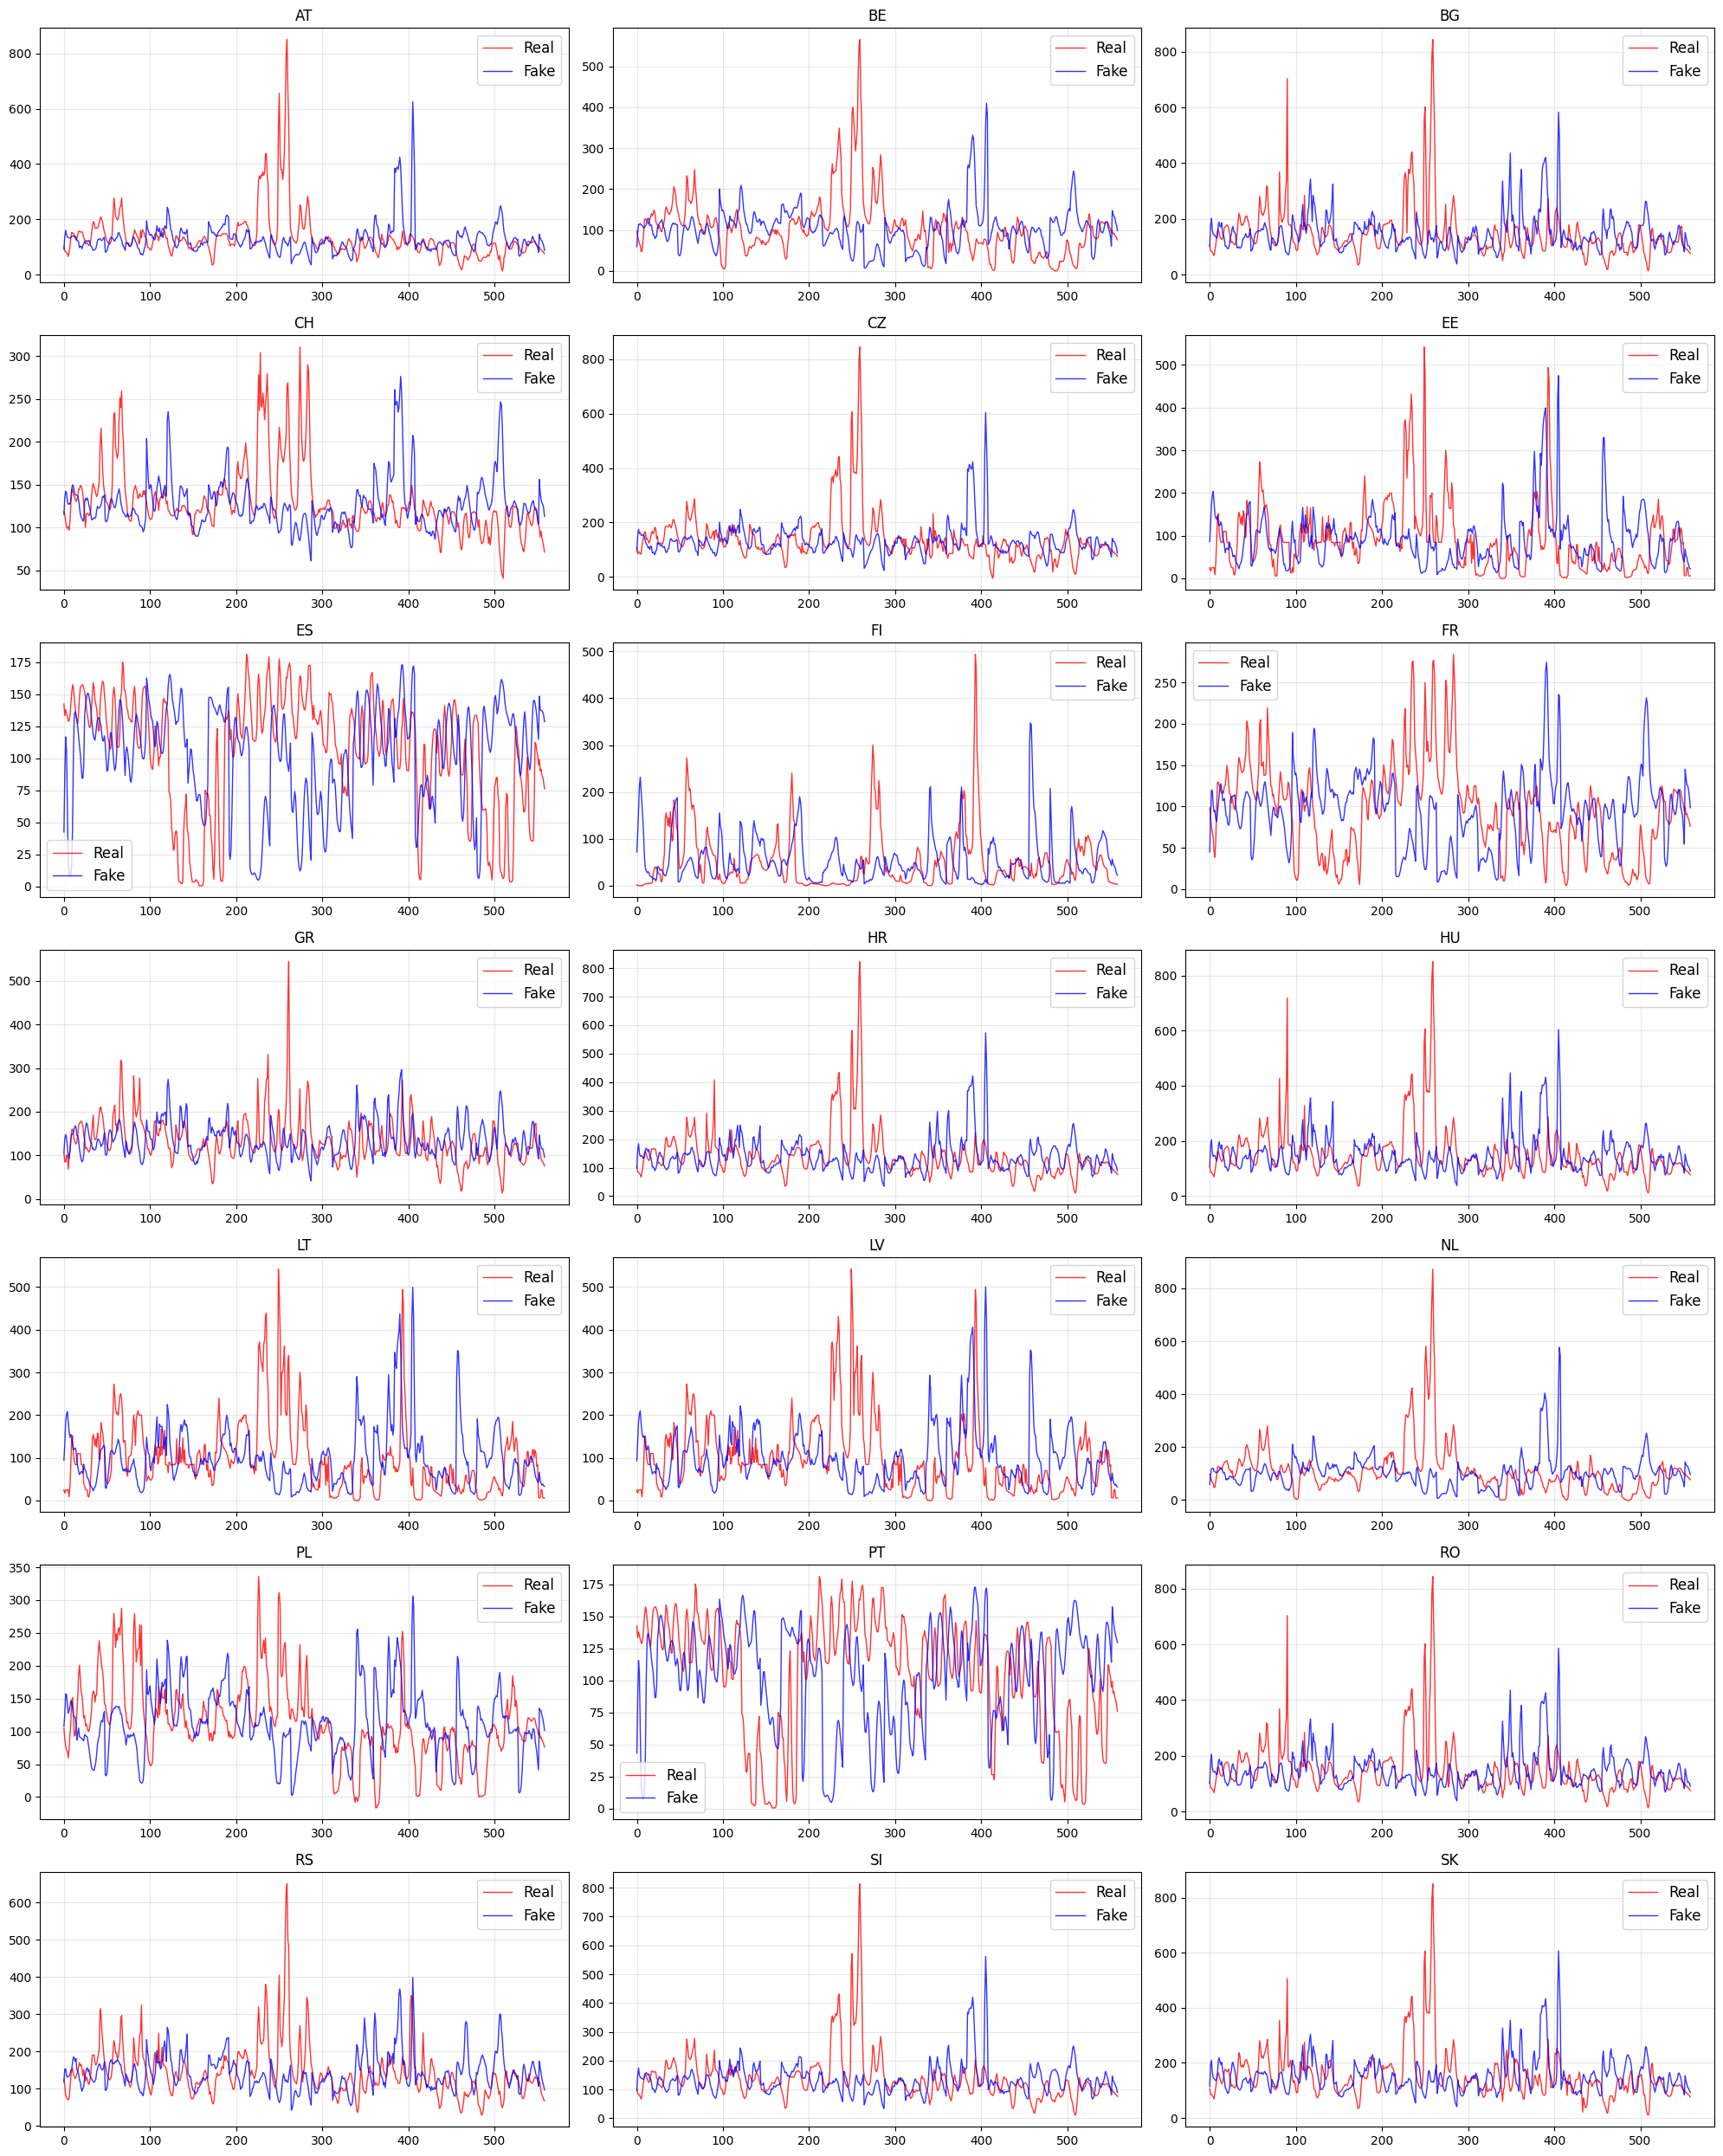

In [24]:
plot_real_vs_fake(reconstructed_vae_real_consecutive, reconstructed_vae_synthetic_consecutive, column_names=original_columns)

In [25]:
reconstructed_timevae_synthetic_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    timevae_synthetic_2, 
    P_train
)


In [26]:
reconstructed_timevae_real_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    X_train, 
    P_train
)


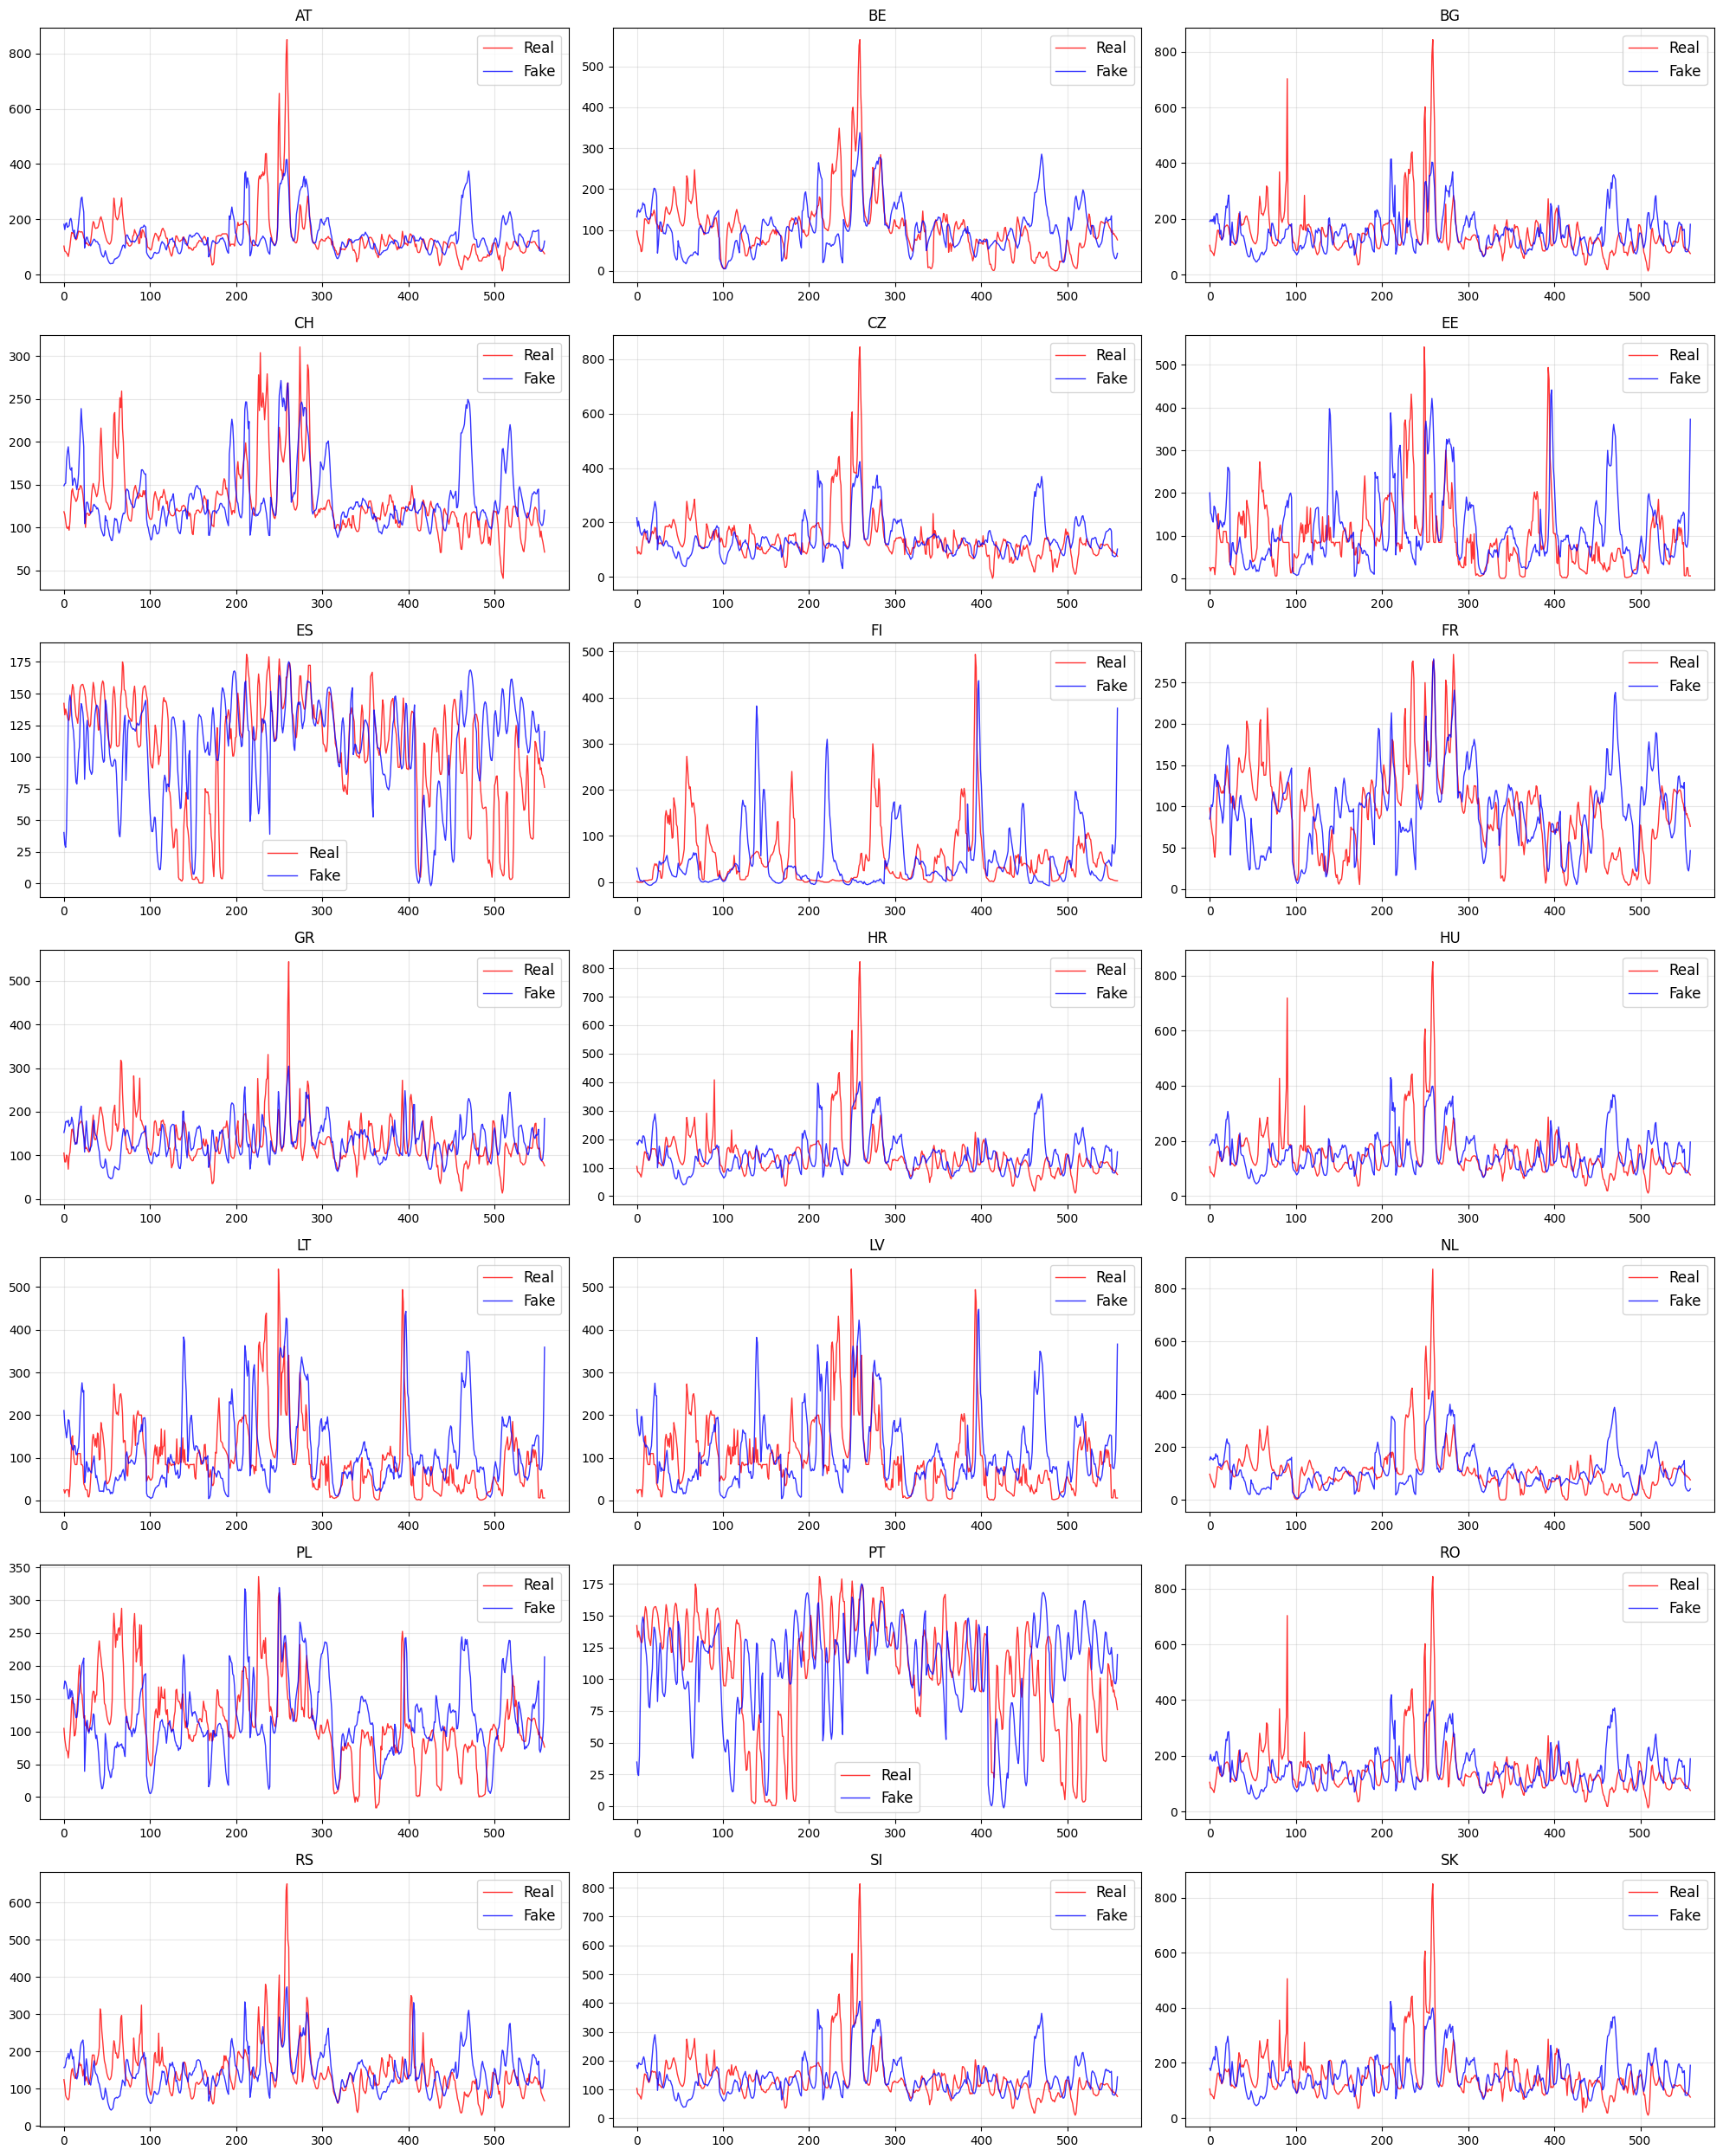

In [27]:
plot_real_vs_fake(reconstructed_timevae_real_consecutive, reconstructed_timevae_synthetic_consecutive, column_names=original_columns)

In [28]:
reconstructed_wgan_synthetic_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    wgan_synthetic_2, 
    P_train
)


In [29]:
reconstructed_wgan_real_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    X_train, 
    P_train
)

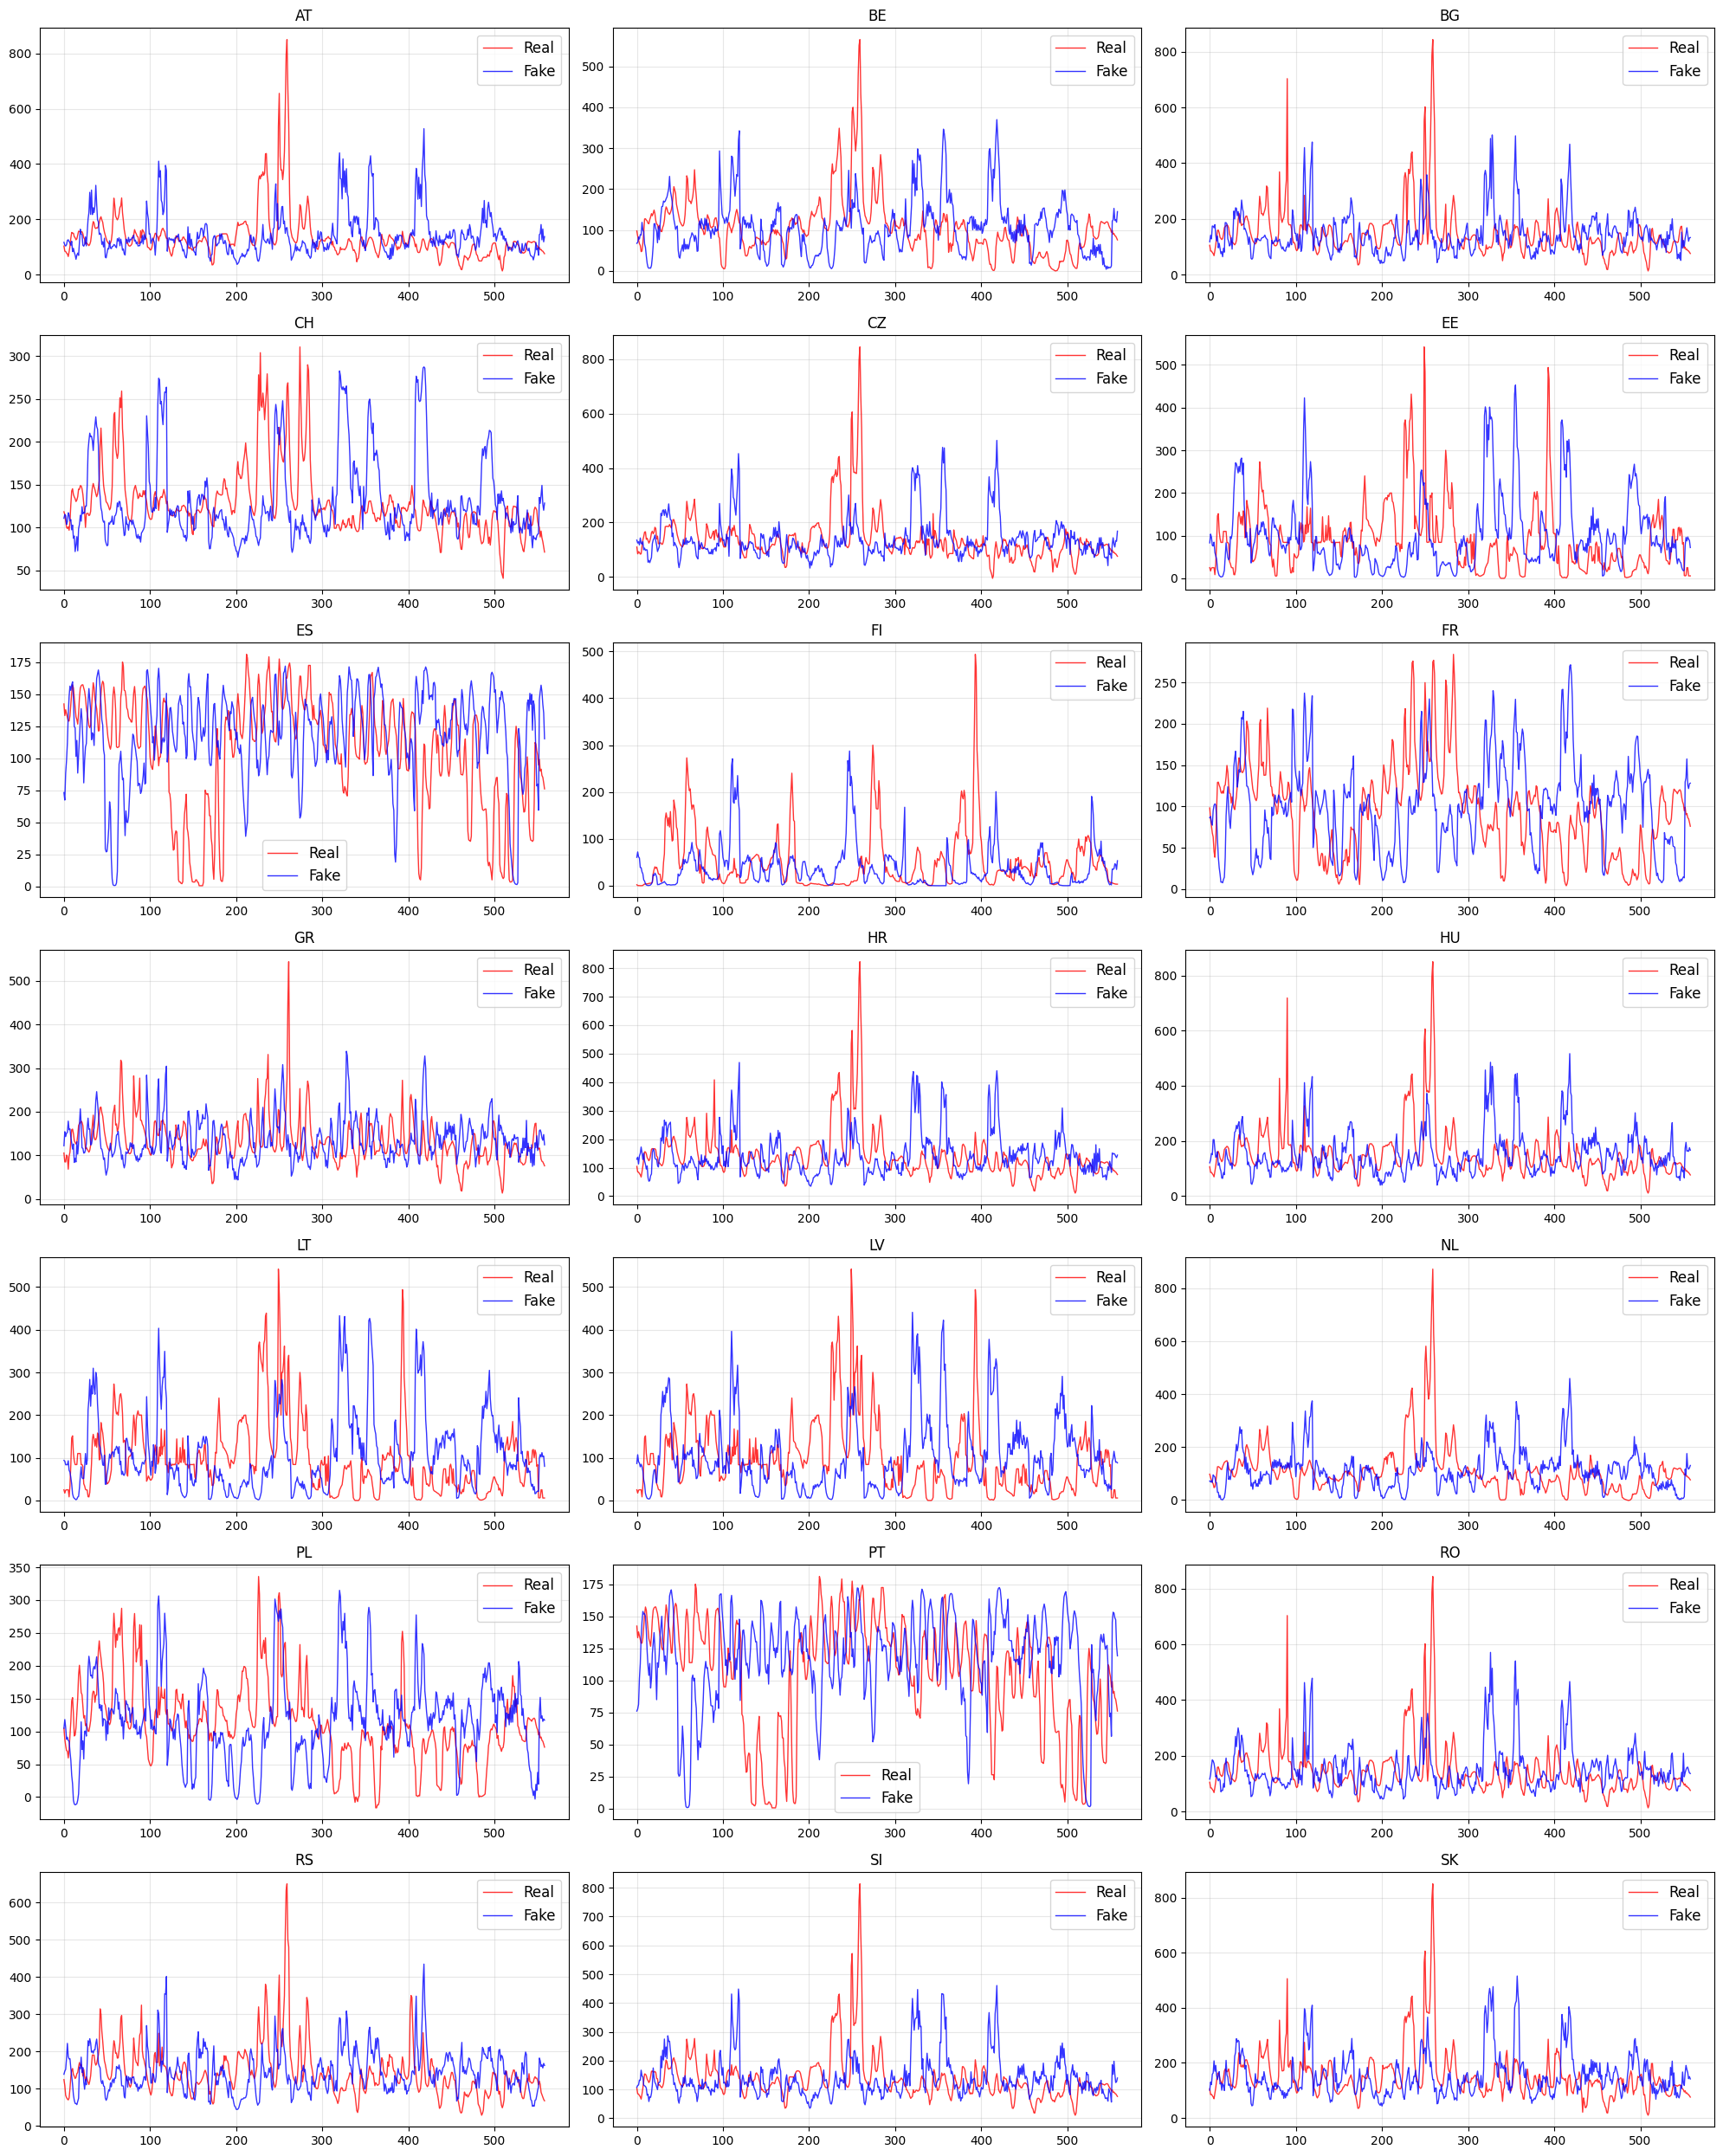

In [30]:
plot_real_vs_fake(reconstructed_wgan_real_consecutive, reconstructed_wgan_synthetic_consecutive, column_names=original_columns)

In [31]:
reconstructed_cwgan_synthetic_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    cwgan_synthetic_2, 
    P_train
)


In [32]:
reconstructed_cwgan_real_consecutive = reconstruct_synthetic_consecutive(
    scaler_2,
    X_train, 
    P_train
)

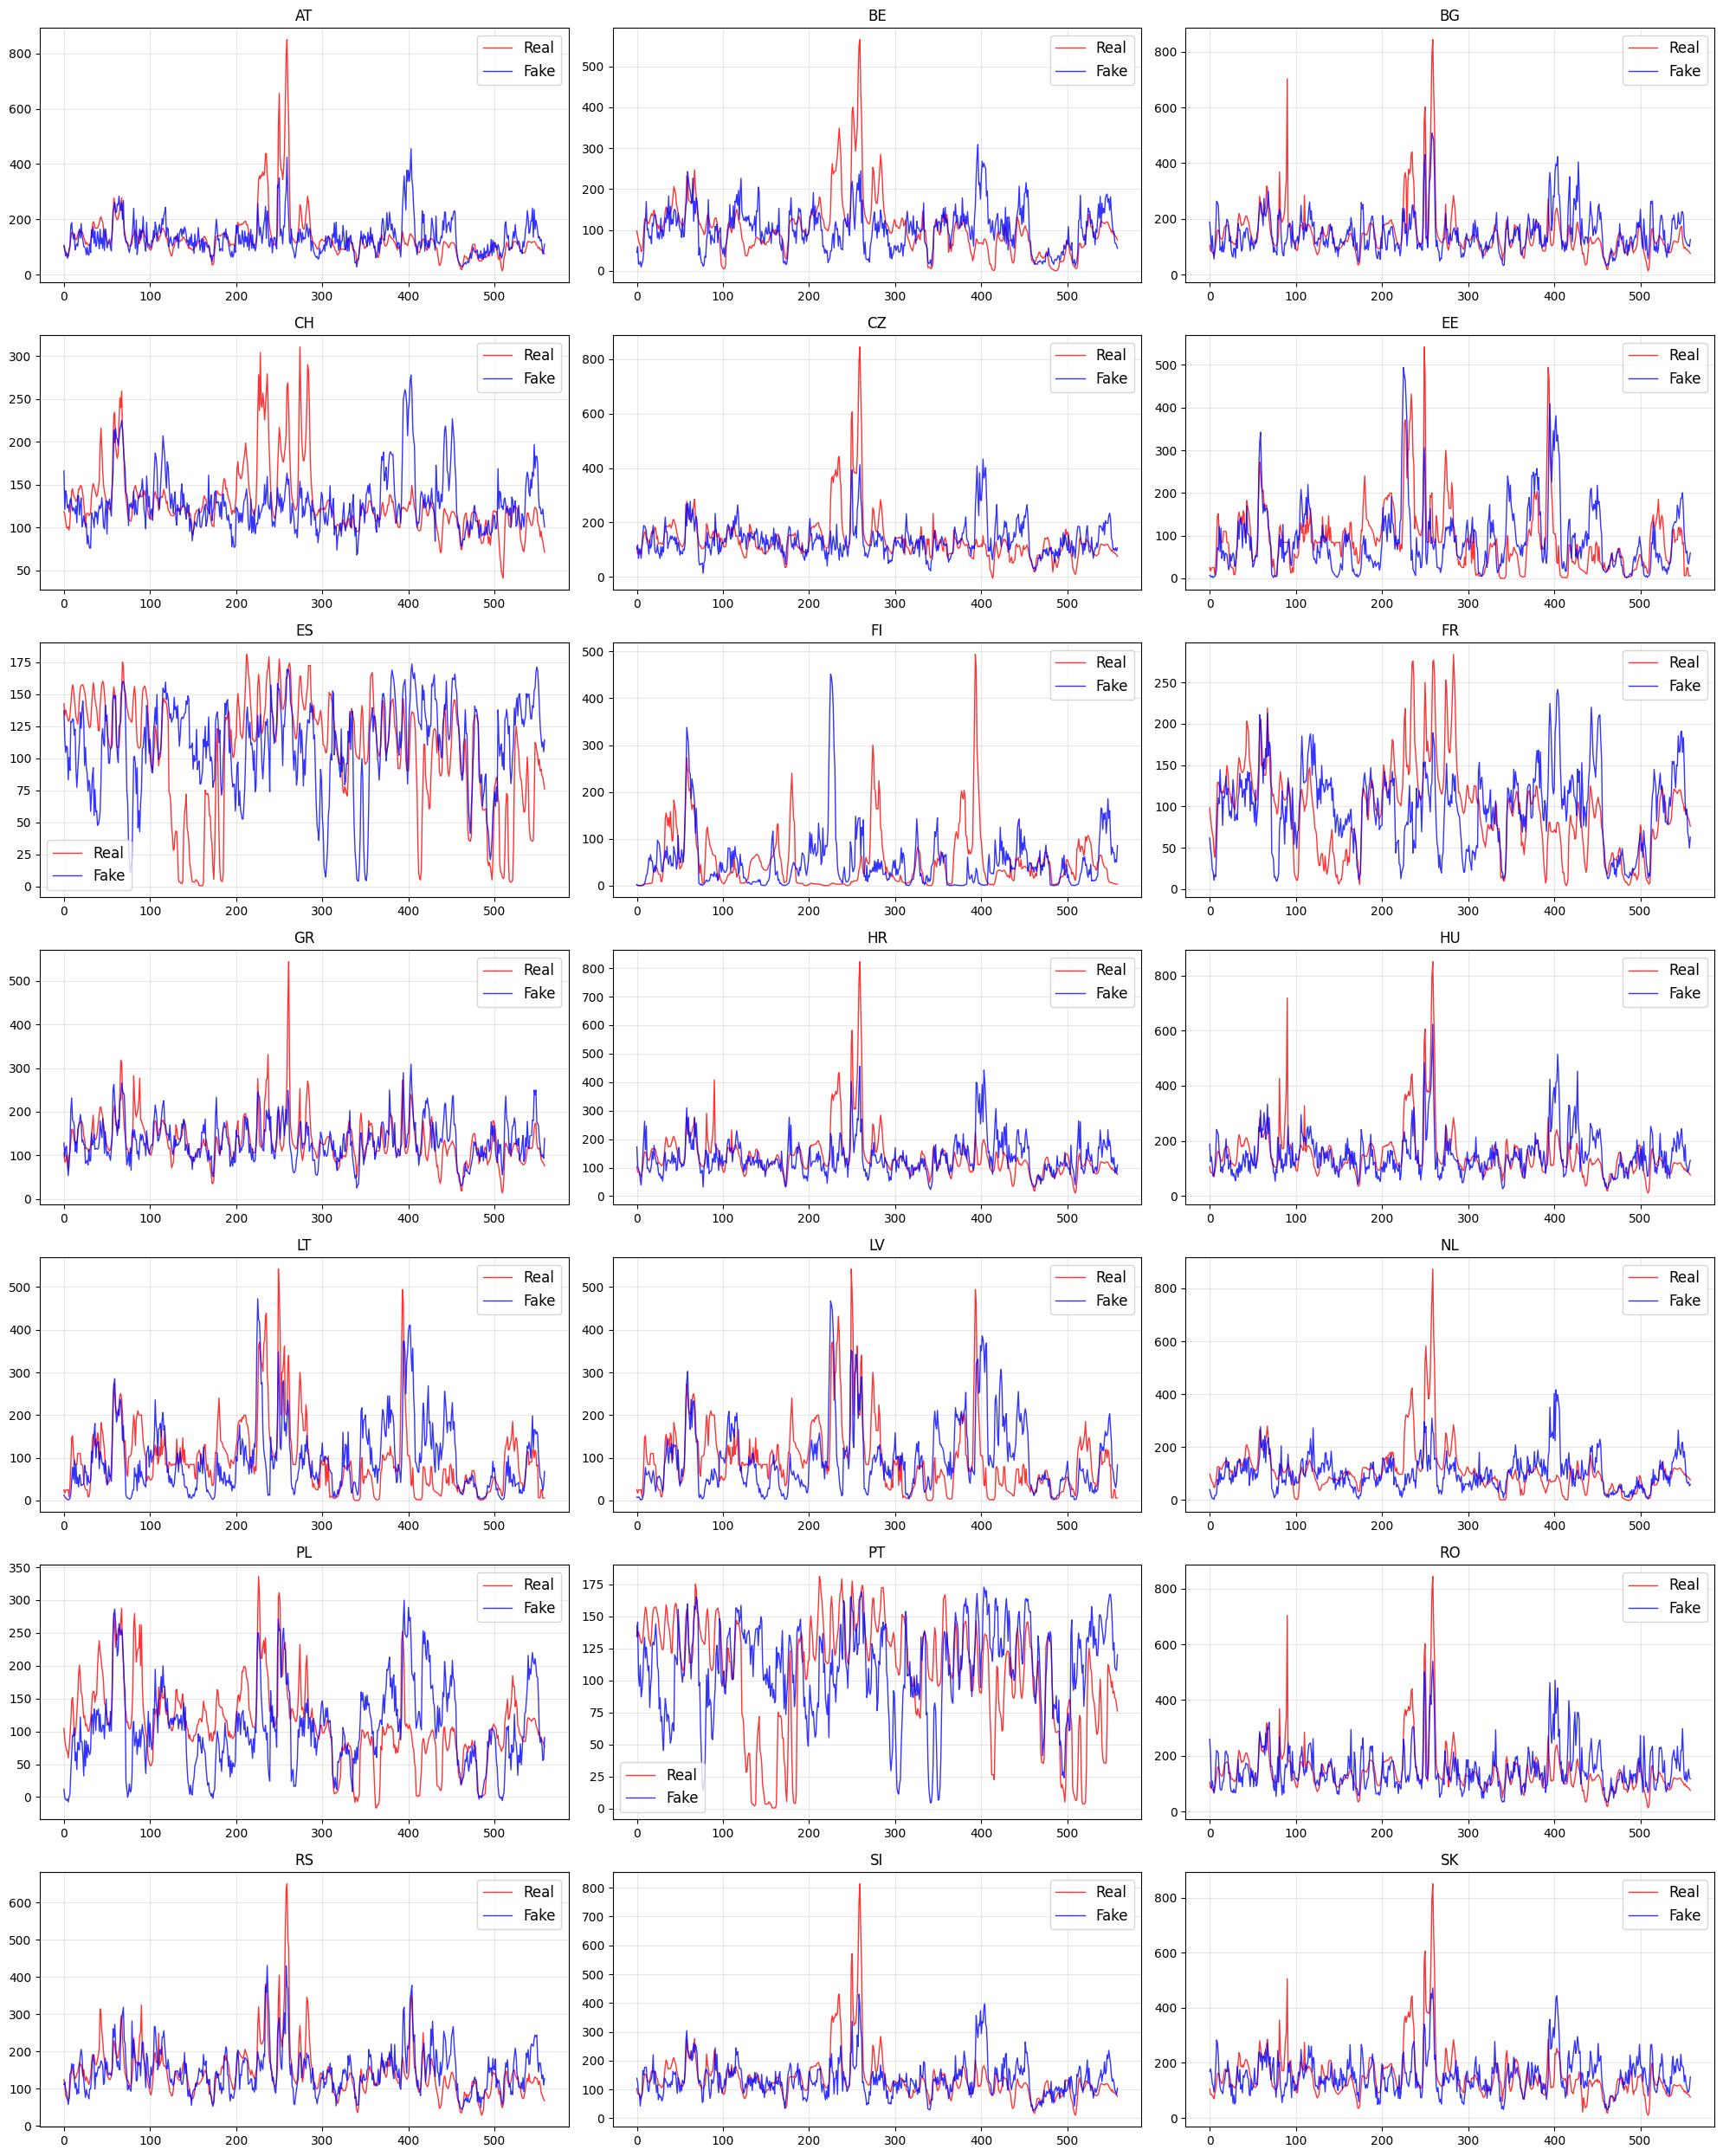

In [33]:
plot_real_vs_fake(reconstructed_cwgan_real_consecutive, reconstructed_cwgan_synthetic_consecutive, column_names=original_columns)

In [45]:
def quantitative_evaluation (eval_fun, real_data, synthetic_data, model_name, context):
    """quantitative evaluation
    
    Args:
        eval_fun: 
        real_data: Real data (n_samples, seq_len, n_features)
        synthetic_data: Synthetic data (n_samples, seq_len, n_features)
        model_name: [vae, timevae, wgan, cwgan]
        context: [TRTR, TSTR, TSRTR]
    Returns:
        quantitative scores for each settings
    """
    scores = []
    for _ in range(5):
        score = eval_fun(real_data, synthetic_data)
        scores.append(score)
    if eval_fun == feature_wise_predictive_score_metrics:
        average_scores = np.mean(scores['average_mae'])
    else:
        average_scores = np.mean(scores)

    print(f"{context} for {model_name} using {eval_fun}:")

    print(f"Individual scores for over 5 runs:", scores)
    print(f"Average score for over 5 runs:", round(average_scores, 4))

In [35]:
quantitative_evaluation(all_feature_predictive_score_metrics,
                        X_train, 
                        vae_synthetic_2, 
                        "vae", 
                        "TSTR"
)

TSTR for vae using <function all_feature_predictive_score_metrics at 0x7f8a1a743b80>:
Individual scores for over 5 runs: [0.030824205, 0.031490687, 0.03111767, 0.030748367, 0.030693473]
Average score for over 5 runs: 0.031


In [40]:
quantitative_evaluation(all_feature_predictive_score_metrics,
                        X_train, 
                        timevae_synthetic_2, 
                        "TimeVAE", 
                        "TSTR"
)

TSTR for TimeVAE using <function all_feature_predictive_score_metrics at 0x7f8a1a743b80>:
Individual scores for over 5 runs: [0.031147707, 0.030764716, 0.031608026, 0.030733323, 0.030435616]
Average score for over 5 runs: 0.0309


In [41]:
quantitative_evaluation(all_feature_predictive_score_metrics,
                        X_train, 
                        combined_vae_2, 
                        "vae", 
                        "TSRTR"
)

TSRTR for vae using <function all_feature_predictive_score_metrics at 0x7f8a1a743b80>:
Individual scores for over 5 runs: [0.025855435, 0.02614691, 0.025896987, 0.025773494, 0.02575868]
Average score for over 5 runs: 0.0259


In [42]:
quantitative_evaluation(all_feature_predictive_score_metrics,
                        X_train, 
                        combined_timevae_2, 
                        "TimeVAE", 
                        "TSRTR"
)

TSRTR for TimeVAE using <function all_feature_predictive_score_metrics at 0x7f8a1a743b80>:
Individual scores for over 5 runs: [0.025551416, 0.02598159, 0.02578413, 0.025692618, 0.025710834]
Average score for over 5 runs: 0.0257


In [43]:
quantitative_evaluation(last_feature_predictive_score_metrics,
                        X_train, 
                        vae_synthetic_2, 
                        "VAE", 
                        "TSTR"
)

17/17 [==============================] - 0s 2ms/step
TSTR for VAE using <function last_feature_predictive_score_metrics at 0x7f8a1a74a1f0>:
Individual scores for over 5 runs: [0.05866538, 0.062559895, 0.074373335, 0.06523729, 0.06870762]
Average score for over 5 runs: 0.0659


In [ ]:
quantitative_evaluation(feature_wise_predictive_score_metrics,
                        X_train, 
                        vae_synthetic_2, 
                        "VAE", 
                        "TSTR"
)

TSTR for VAE using <function feature_wise_predictive_score_metrics_temp at 0x7f8a1d6641f0>:
Individual scores for over 5 runs: [0.07620646, 0.07583853, 0.075334206, 0.07565764, 0.07417836]
Average score for over 5 runs: 0.0754


In [ ]:
quantitative_evaluation(discriminative_score,
                        X_train, 
                        vae_synthetic_2, 
                        "VAE", 
                        "Discriminative Score"
)

Discriminative Score for VAE using <function discriminative_score at 0x7f8a2fb24e50>:
Individual scores for over 5 runs: [0.0767441987991333, 0.006976723670959473, 0.03953486680984497, 0.030232548713684082, 0.002325594425201416]
Average score for over 5 runs: 0.0312


In [ ]:
quantitative_evaluation(classification_score,
                        X_train, 
                        vae_synthetic_2, 
                        "VAE", 
                        "TSTR"
)

TSTR for VAE using <function classification_score_temp at 0x7f89f8f521f0>:
Individual scores for over 5 runs: [0.7920220345258713, 0.7898010015487671, 0.7976190447807312, 0.7890014201402664, 0.783226728439331]
Average score for over 5 runs: 0.7903
